[ERROR] Missing required variable in ./sensitivity_analysis_runs5/sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[ERROR] Missing required variable in ./sensitivity_analysis_runs5/sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[ERROR] Missing required variable in ./sensitivity_analysis_runs5/sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 

/var/folders/hw/y4klzjqd4r9b2k9kpqcs_qth0000gn/T/ipykernel_2340/1632553083.py:153: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



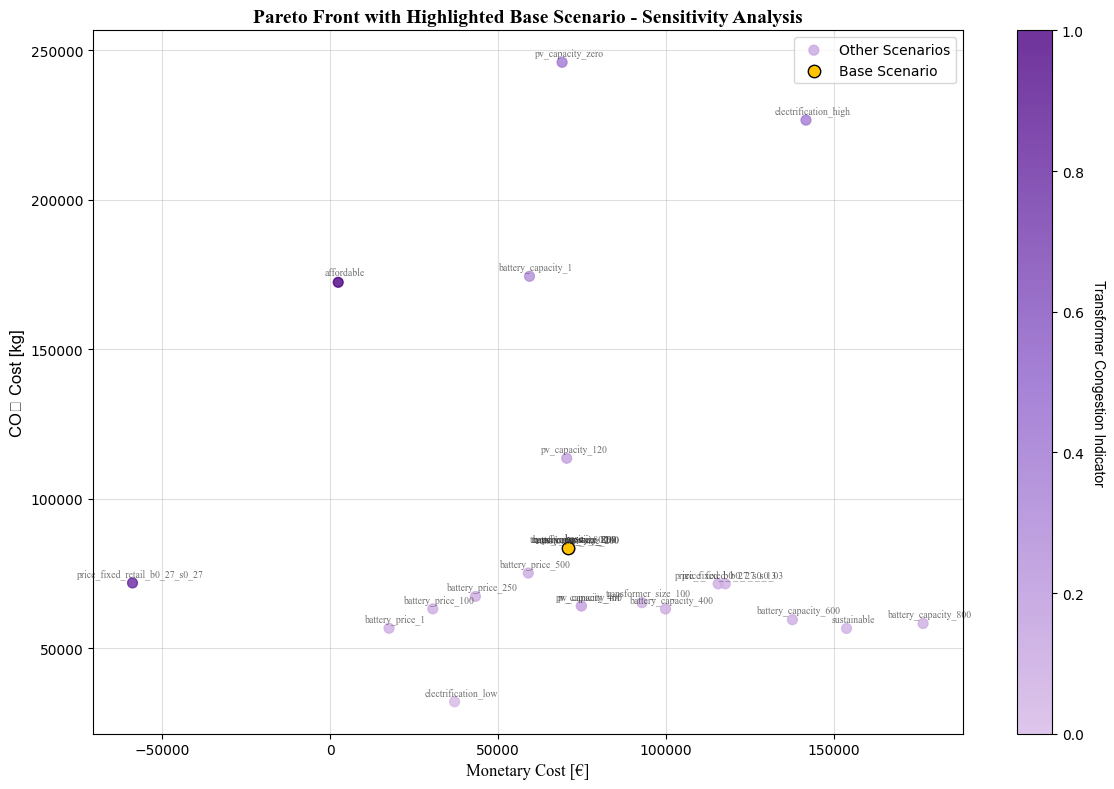

In [24]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs5"

# Verify if the directory exists
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")

# ----------------------------
# 📊 Extract Costs from NetCDF Files
# ----------------------------
def extract_costs_from_netcdf(file_path):
    """
    Extract monetary, CO2, and transformer congestion costs from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        monetary_cost = model['cost'].sel(costs='monetary').sum().values.item()
        co2_cost = model['cost'].sel(costs='co2_emissions').sum().values.item()
        transformer_cost = model['cost'].sel(costs='transformer_congestion_indicator').sum().values.item()
        
        return {
            "monetary_cost": monetary_cost,
            "co2_cost": co2_cost,
            "transformer_congestion_indicator": transformer_cost
        }
    except KeyError as e:
        print(f"[ERROR] Missing required variable in {file_path}: {e}")
        return None
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return None


# ----------------------------
# 📑 Aggregate Costs from All Scenarios
# ----------------------------
scenario_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc')]
cost_data = []

for scenario_file in scenario_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    scenario_name = os.path.splitext(scenario_file)[0].replace('sensitivity_', '')  # Remove 'sensitivity_'
    costs = extract_costs_from_netcdf(scenario_path)
    
    if costs:
        costs["scenario"] = scenario_name  # Add clean scenario name to the data
        cost_data.append(costs)

# Create DataFrame
if not cost_data:
    raise ValueError("No valid cost data found in the NetCDF files.")

df_costs = pd.DataFrame(cost_data)

# Reorder columns for clarity
df_costs = df_costs[["scenario", "monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# ----------------------------
# 🛠️ Normalize Transformer Congestion Indicator
# ----------------------------
df_costs["transformer_congestion_indicator"] = (
    (df_costs["transformer_congestion_indicator"] - df_costs["transformer_congestion_indicator"].min()) /
    (df_costs["transformer_congestion_indicator"].max() - df_costs["transformer_congestion_indicator"].min())
)

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
accenture_cmap = LinearSegmentedColormap.from_list(
    "accenture", ["#D6B8E6", "#9063CD", "#4B0082"]
)

# ----------------------------
# 📊 Plot Pareto Front with Highlighted Base Scenario
# ----------------------------
plt.figure(figsize=(12, 8))

# Plot all scenarios except 'sensitivity_base'
base_scenario = df_costs[df_costs["scenario"] == "base"]
other_scenarios = df_costs[df_costs["scenario"] != "base"]

# Plot other scenarios
scatter = plt.scatter(
    other_scenarios["monetary_cost"],
    other_scenarios["co2_cost"],
    c=other_scenarios["transformer_congestion_indicator"],  # Color by transformer congestion
    cmap=accenture_cmap,
    alpha=0.8,
    s=50,  # Dot size
    label="Other Scenarios"
)

# Highlight the 'sensitivity_base' scenario in gold/yellow
if not base_scenario.empty:
    plt.scatter(
        base_scenario["monetary_cost"],
        base_scenario["co2_cost"],
        color="#FFC300",  # Accenture Gold
        edgecolor="black",
        alpha=1,
        s=80,  # Slightly larger dot size
        label="Base Scenario"
    )

# Add color bar for transformer congestion indicator
cbar = plt.colorbar(scatter)
cbar.set_label("Transformer Congestion Indicator", rotation=270, labelpad=15, fontname='Arial')

# Set plot labels and title
plt.xlabel("Monetary Cost [€]", fontname='Times New Roman', fontsize=12)
plt.ylabel("CO₂ Cost [kg]", fontname='Arial', fontsize=12)  # Fallback font for subscript "₂"
plt.title("Pareto Front with Highlighted Base Scenario - Sensitivity Analysis", fontname='Times New Roman', fontsize=14, fontweight='bold')

# Add clean scenario names as annotations
for i, row in df_costs.iterrows():
    if row['scenario'] == 'base':
        plt.annotate(
            row['scenario'],
            (row['monetary_cost'], row['co2_cost']),
            textcoords="offset points",
            xytext=(5, 5),
            ha='center',
            fontsize=8,
            color='#2C2C2C',
            fontname='Times New Roman'
        )
    else:
        plt.annotate(
            row['scenario'],
            (row['monetary_cost'], row['co2_cost']),
            textcoords="offset points",
            xytext=(5, 5),
            ha='center',
            fontsize=7,
            color='#2C2C2C',
            alpha=0.7,
            fontname='Times New Roman'
        )

# Add legend
plt.legend(loc='upper right', fontsize=10, frameon=True)

# Improve layout
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

[ERROR] Missing required variable in ./sensitivity_analysis_runs5/sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[ERROR] Missing required variable in ./sensitivity_analysis_runs5/sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[ERROR] Missing required variable in ./sensitivity_analysis_runs5/sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 

/var/folders/hw/y4klzjqd4r9b2k9kpqcs_qth0000gn/T/ipykernel_2340/3680023381.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.

/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.



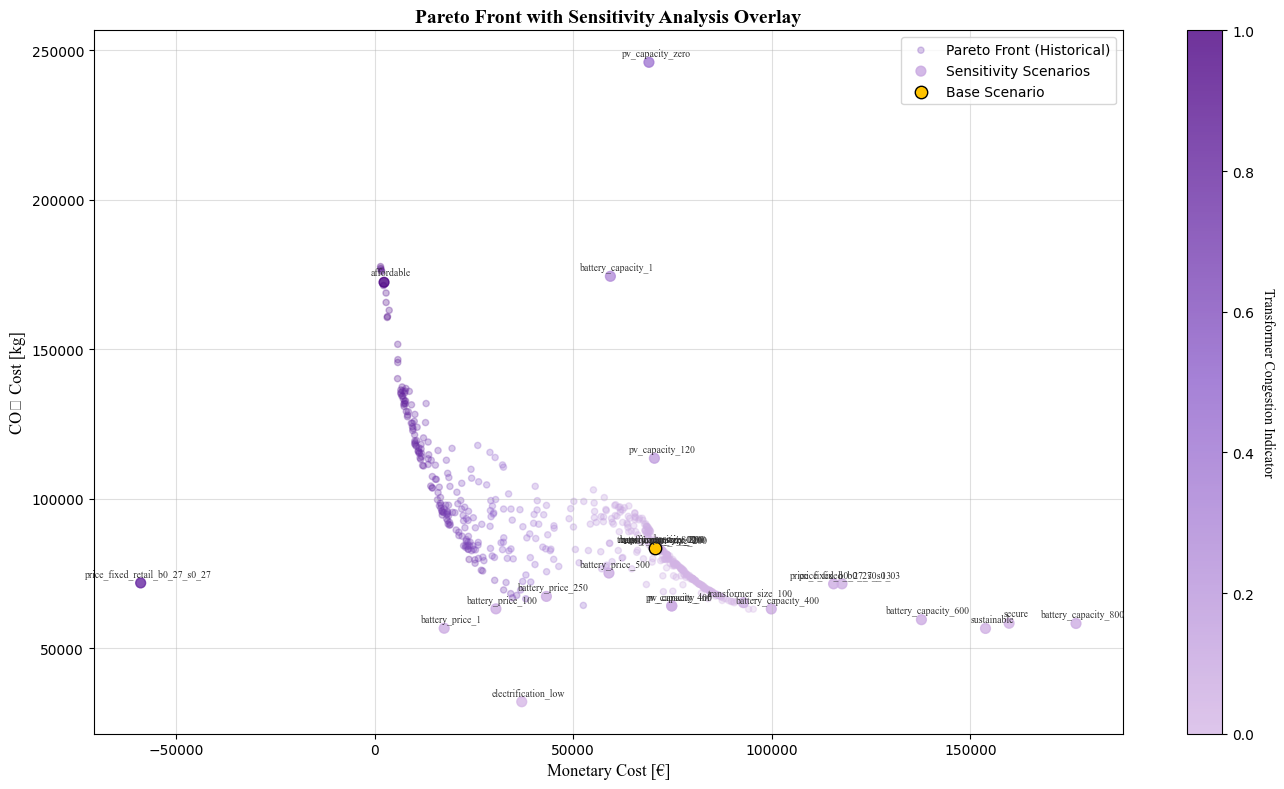

In [28]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs5"
PARETO_FILE = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/pareto_fronts/pareto_front_runs_dirichlet/all_results.csv"

# Verify directories
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")

if not os.path.exists(PARETO_FILE):
    raise FileNotFoundError(f"The Pareto results file '{PARETO_FILE}' does not exist.")

# ----------------------------
# 📊 Extract Costs from NetCDF Files
# ----------------------------
def extract_costs_from_netcdf(file_path):
    """
    Extract monetary, CO2, and transformer congestion costs from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        monetary_cost = model['cost'].sel(costs='monetary').sum().values.item()
        co2_cost = model['cost'].sel(costs='co2_emissions').sum().values.item()
        transformer_cost = model['cost'].sel(costs='transformer_congestion_indicator').sum().values.item()
        
        return {
            "monetary_cost": monetary_cost,
            "co2_cost": co2_cost,
            "transformer_congestion_indicator": transformer_cost
        }
    except KeyError as e:
        print(f"[ERROR] Missing required variable in {file_path}: {e}")
        return None
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return None


# ----------------------------
# 📑 Aggregate Costs from All Scenarios
# ----------------------------
scenario_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc')]
cost_data = []

for scenario_file in scenario_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    scenario_name = os.path.splitext(scenario_file)[0].replace('sensitivity_', '')  # Remove 'sensitivity_'
    costs = extract_costs_from_netcdf(scenario_path)
    
    if costs:
        costs["scenario"] = scenario_name  # Add clean scenario name to the data
        cost_data.append(costs)

# Create DataFrame
if not cost_data:
    raise ValueError("No valid cost data found in the NetCDF files.")

df_costs = pd.DataFrame(cost_data)

# Reorder columns for clarity
df_costs = df_costs[["scenario", "monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# Normalize Transformer Congestion Indicator
df_costs["transformer_congestion_indicator"] = (
    (df_costs["transformer_congestion_indicator"] - df_costs["transformer_congestion_indicator"].min()) /
    (df_costs["transformer_congestion_indicator"].max() - df_costs["transformer_congestion_indicator"].min())
)

# ----------------------------
# 📊 Load Pareto Front Data
# ----------------------------
pareto_data = pd.read_csv(PARETO_FILE)
pareto_data = pareto_data[["monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# Filter extreme values
pareto_data = pareto_data[
    (pareto_data["monetary_cost"] <= pareto_data["monetary_cost"].quantile(1)) &
    (pareto_data["co2_cost"] <= pareto_data["co2_cost"].quantile(1)) &
    (pareto_data["transformer_congestion_indicator"] <= pareto_data["transformer_congestion_indicator"].quantile(1))
]

# Normalize Transformer Congestion Indicator for Pareto Front
pareto_data["transformer_congestion_indicator"] = (
    (pareto_data["transformer_congestion_indicator"] - pareto_data["transformer_congestion_indicator"].min()) /
    (pareto_data["transformer_congestion_indicator"].max() - pareto_data["transformer_congestion_indicator"].min())
)

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
accenture_cmap = LinearSegmentedColormap.from_list(
    "accenture", ["#D6B8E6", "#9063CD", "#4B0082"]
)

# ----------------------------
# 📊 Plot Combined Pareto Front and Sensitivity Scenarios
# ----------------------------
plt.figure(figsize=(14, 8))

# Plot Pareto Front in background
plt.scatter(
    pareto_data["monetary_cost"],
    pareto_data["co2_cost"],
    c=pareto_data["transformer_congestion_indicator"],
    cmap=accenture_cmap,
    alpha=0.3,
    s=20,
    label="Pareto Front (Historical)"
)

# Plot other scenarios
other_scenarios = df_costs[df_costs["scenario"] != "base"]
scatter = plt.scatter(
    other_scenarios["monetary_cost"],
    other_scenarios["co2_cost"],
    c=other_scenarios["transformer_congestion_indicator"],  # Color by transformer congestion
    cmap=accenture_cmap,
    alpha=0.8,
    s=50,
    label="Sensitivity Scenarios"
)

# Highlight the 'sensitivity_base' scenario in gold/yellow
base_scenario = df_costs[df_costs["scenario"] == "base"]
if not base_scenario.empty:
    plt.scatter(
        base_scenario["monetary_cost"],
        base_scenario["co2_cost"],
        color="#FFC300",  # Accenture Gold
        edgecolor="black",
        alpha=1,
        s=80,
        label="Base Scenario"
    )

# Add color bar for transformer congestion indicator
cbar = plt.colorbar(scatter)
cbar.set_label("Transformer Congestion Indicator", rotation=270, labelpad=15, fontname='Times New Roman')

# Set plot labels and title
plt.xlabel("Monetary Cost [€]", fontname='Times New Roman', fontsize=12)
plt.ylabel("CO₂ Cost [kg]", fontname='Times New Roman', fontsize=12)
plt.title("Pareto Front with Sensitivity Analysis Overlay", fontname='Times New Roman', fontsize=14, fontweight='bold')

# Add clean scenario names as annotations
for i, row in df_costs.iterrows():
    plt.annotate(
        row['scenario'],
        (row['monetary_cost'], row['co2_cost']),
        textcoords="offset points",
        xytext=(5, 5),
        ha='center',
        fontsize=7,
        color='#2C2C2C',
        fontname='Times New Roman'
    )

# Add legend
plt.legend(loc='upper right', fontsize=10, frameon=True)

# Improve layout
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

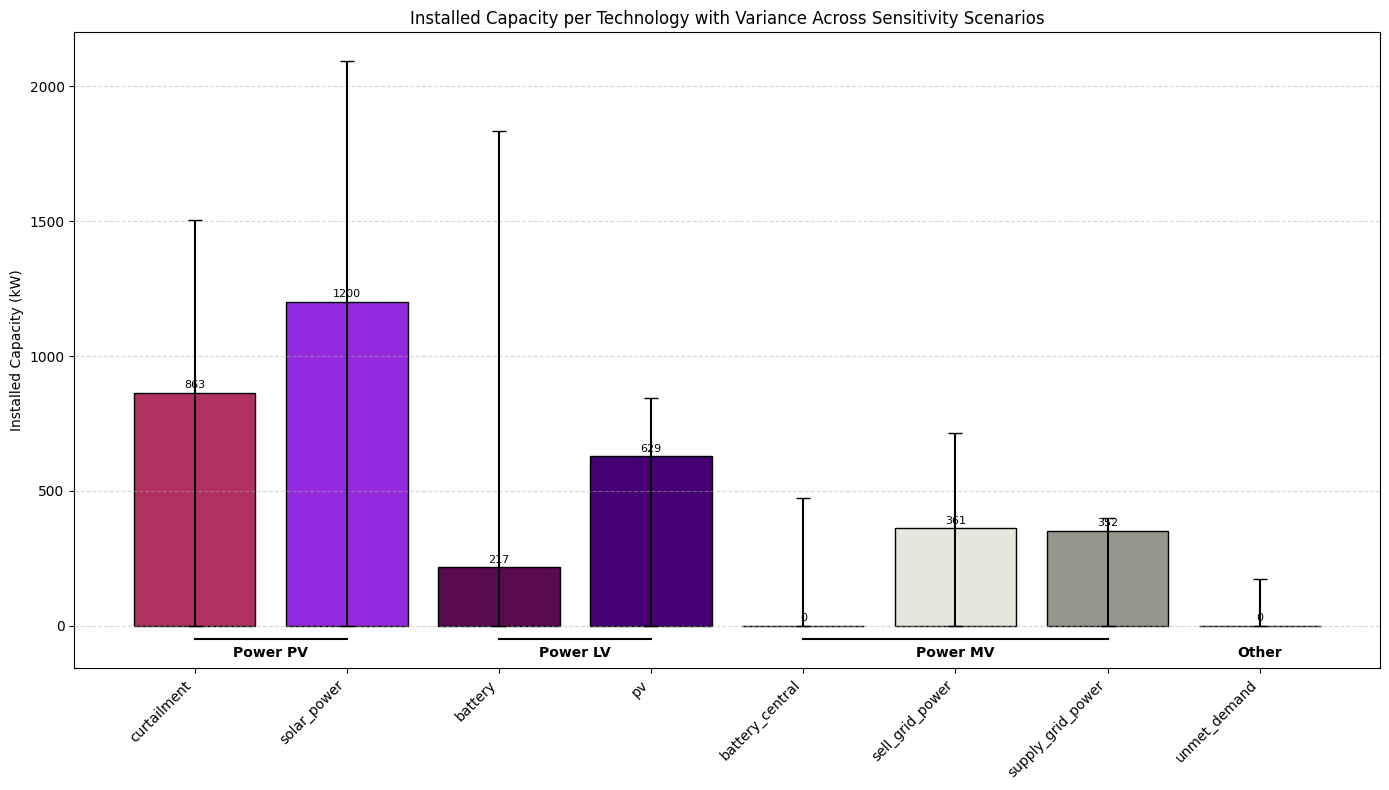

In [19]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs4"
BASE_SCENARIO = "./sensitivity_analysis_runs4/sensitivity_base.nc"

# Verify if directories exist
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")
if not os.path.exists(BASE_SCENARIO):
    raise FileNotFoundError(f"The base scenario file '{BASE_SCENARIO}' does not exist.")

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
tech_colors = {
    "supply_grid_power": "#96968c",  
    "solar_power": "#942adf",        
    "unmet_demand": "#d62128",       
    "sell_grid_power": "#e6e6dc",    
    "curtailment": "#b03060",        
    "pv": "#460073",                 
    "battery": "#5a0a4f",            
    "battery_central": "#5a0a3f"     
}

tech_carriers = {
    "solar_power": "Power PV",
    "curtailment": "Power PV",
    "pv": "Power LV",
    "battery": "Power LV",
    "sell_grid_power": "Power MV",
    "supply_grid_power": "Power MV",
    "battery_central": "Power MV",
    "unmet_demand": "Other"
}

# Sorting order for categories
carrier_sort_order = ["Power PV", "Power LV", "Power MV", "Other"]

# Selected technologies
selected_techs_power_PV = ["solar_power", "curtailment"]
selected_techs_power_LV = ["pv", "battery"]
selected_techs_power_MV = ["sell_grid_power", "supply_grid_power", "battery_central"]
selected_techs_other = ["unmet_demand"]

selected_techs = selected_techs_power_PV + selected_techs_power_LV + selected_techs_power_MV + selected_techs_other

# ----------------------------
# 📊 Extract Installed Capacity from NetCDF
# ----------------------------
def extract_installed_capacity(file_path):
    """
    Extract installed capacity per technology from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        df_capacity = (
            model["flow_cap"]
            .sum(dim="nodes")
            .to_dataframe(name="installed_capacity")
            .reset_index()
        )

        # Handle PV double counting
        df_pv = df_capacity[df_capacity["techs"] == "pv"].copy()
        if not df_pv.empty:
            df_pv["installed_capacity"] = df_pv["installed_capacity"] / 2
            df_capacity.loc[df_capacity["techs"] == "pv", "installed_capacity"] = df_pv["installed_capacity"]

        # Filter for selected technologies
        df_capacity = df_capacity[df_capacity["techs"].isin(selected_techs)]

        # Remove duplicate technologies, keep the first occurrence
        df_capacity = df_capacity.groupby("techs", as_index=False).agg({"installed_capacity": "sum"})

        return df_capacity
    except KeyError as e:
        print(f"[ERROR] Missing required variable in {file_path}: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return pd.DataFrame()


# ----------------------------
# 📑 Aggregate Base Scenario and Sensitivity Scenarios
# ----------------------------
# Base scenario
df_base = extract_installed_capacity(BASE_SCENARIO)
df_base["carrier"] = df_base["techs"].map(tech_carriers).fillna("Other")

# Sensitivity scenarios
sensitivity_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc') and f != os.path.basename(BASE_SCENARIO)]
sensitivity_data = []

for scenario_file in sensitivity_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    df_sensitivity = extract_installed_capacity(scenario_path)
    df_sensitivity["carrier"] = df_sensitivity["techs"].map(tech_carriers).fillna("Other")
    sensitivity_data.append(df_sensitivity)

# Combine all sensitivity data
df_sensitivity_combined = pd.concat(sensitivity_data, ignore_index=True)

# Calculate variance (min and max installed capacity per tech)
df_variance = df_sensitivity_combined.groupby("techs")["installed_capacity"].agg(["min", "max"]).reset_index()

# Merge with base scenario
df_plot = pd.merge(df_base, df_variance, on="techs", how="left")

# Ensure no NaN in variance columns
df_plot['min'] = df_plot['min'].fillna(df_plot['installed_capacity'])
df_plot['max'] = df_plot['max'].fillna(df_plot['installed_capacity'])

# ----------------------------
# 📊 Sorting by Carrier
# ----------------------------
df_plot["carrier"] = df_plot["techs"].map(tech_carriers).fillna("Other")
df_plot["carrier_order"] = df_plot["carrier"].apply(lambda x: carrier_sort_order.index(x))
df_plot = df_plot.sort_values(by=["carrier_order", "techs"]).reset_index(drop=True)

# ----------------------------
# 📊 Plotting with Carrier Brackets
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 8))

# Track x-axis positions
x_positions = np.arange(len(df_plot))

# Plot technologies with variance
for i, row in df_plot.iterrows():
    tech = row['techs']
    base_capacity = row['installed_capacity']
    min_capacity = row['min']
    max_capacity = row['max']

    ax.bar(
        x_positions[i],
        base_capacity,
        color=tech_colors.get(tech, "#cccccc"),
        edgecolor="black"
    )

    ax.errorbar(
        x_positions[i],
        base_capacity,
        yerr=[[base_capacity - min_capacity], [max_capacity - base_capacity]],
        fmt='none',
        ecolor='black',
        capsize=5,
        capthick=1
    )

    ax.text(
        x_positions[i],
        base_capacity + 10,
        f"{base_capacity:.0f}",
        ha='center',
        va='bottom',
        fontsize=8
    )

# Grouping Technologies with Brackets
for carrier in carrier_sort_order:
    indices = df_plot[df_plot["carrier"] == carrier].index.tolist()
    if indices:
        ax.plot(
            [indices[0], indices[-1]],
            [-50, -50],
            color='black'
        )
        ax.text(
            (indices[0] + indices[-1]) / 2,
            -100,
            carrier,
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold'
        )

# Aesthetics
ax.set_xticks(x_positions)
ax.set_xticklabels(df_plot["techs"], rotation=45, ha="right")
ax.set_ylabel('Installed Capacity (kW)')
ax.set_title('Installed Capacity per Technology with Variance Across Sensitivity Scenarios')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()